In [ ]:
# !pip install keras-tuner --upgrade

In [103]:
# Keras & Tensorflow libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
import keras_tuner as kt

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# sklearn libraries
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder, Normalizer

# Choosing GPU

In [44]:
phy_devices = tf.config.experimental.list_physical_devices('GPU')
print("GPU's available: ", len(phy_devices))
# tf.config.experimental.set_memory_growth(phy_devices[0], True) # uncomment this if gpu is found to use it

GPU's available:  0


# Reading the dataset

In [45]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Pre-processing the data

In [46]:
imputer_cols = ["Age", "FoodCourt", "ShoppingMall", "Spa", "VRDeck" ,"RoomService"]
imputer = SimpleImputer()
imputer.fit(train[imputer_cols])
train[imputer_cols] = imputer.transform(train[imputer_cols])
test[imputer_cols] = imputer.transform(test[imputer_cols])

In [47]:
train['HomePlanet'].fillna('Earth', inplace=True)
train['CryoSleep'].fillna('False', inplace=True)
train['Cabin'].fillna('None', inplace=True)
train['Destination'].fillna('TRAPPIST-1e', inplace=True)
train['VIP'].fillna('False', inplace=True)

test['HomePlanet'].fillna('Earth', inplace=True)
test['CryoSleep'].fillna('False', inplace=True)
test['Cabin'].fillna('G/109/P', inplace=True)
test['Destination'].fillna('TRAPPIST-1e', inplace=True)
test['VIP'].fillna('False', inplace=True)

train['Name'].fillna('no name', inplace=True)
test['Name'].fillna('no name', inplace=True)

# Feature Engineering

In [48]:
train['Deck'] = train['Cabin'].apply(lambda x:str(x)[:1])
train['Side'] = train['Cabin'].apply(lambda x:str(x)[-1:])
test['Deck'] = train['Cabin'].apply(lambda x:str(x)[:1])
test['Side'] = train['Cabin'].apply(lambda x:str(x)[-1:])

train['PGroup'] = train['PassengerId'].apply(lambda x: x.split('_')[0])
train['PNumber'] = train['PassengerId'].apply(lambda x: x.split('_')[1])
test['PGroup'] = test['PassengerId'].apply(lambda x: x.split('_')[0])
test['PNumber'] = test['PassengerId'].apply(lambda x: x.split('_')[1])

train['LastName'] = train['Name'].apply(lambda x:x.split(" ")[1])
test['LastName'] = train['Name'].apply(lambda x:x.split(" ")[1])

train['AllServices'] = train['RoomService'] + train['FoodCourt'] + train['ShoppingMall'] + train['Spa'] + train['VRDeck']
test['AllServices'] = test['RoomService'] + test['FoodCourt'] + test['ShoppingMall'] + test['Spa'] + test['VRDeck']

In [49]:
label_cols = ["HomePlanet", "CryoSleep", "Destination" ,"VIP", "Deck", "Side", "LastName", "PGroup", "PNumber"]

for i in label_cols:
    train[i] = train[i].astype(str)
    test[i] = test[i].astype(str)
    train[i] = LabelEncoder().fit_transform(train[i])
    test[i] = LabelEncoder().fit_transform(test[i])

In [50]:
train['Transported'] = LabelEncoder().fit_transform(train['Transported'])
train

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,Side,PGroup,PNumber,LastName,AllServices
0,0001_01,1,0,B/0/P,2,39.0,0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0,1,0,0,0,1431,0.0
1,0002_01,0,0,F/0/S,2,24.0,0,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1,5,1,1,0,2109,736.0
2,0003_01,1,0,A/0/S,2,58.0,1,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0,0,1,2,0,1990,10383.0
3,0003_02,1,0,A/0/S,2,33.0,0,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,0,0,1,2,1,1990,5176.0
4,0004_01,0,0,F/1/S,2,16.0,0,303.0,70.0,151.0,565.0,2.0,Willy Santantines,1,5,1,3,0,1778,1091.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,1,0,A/98/P,0,41.0,1,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,0,0,0,6213,0,1416,8536.0
8689,9278_01,0,1,G/1499/S,1,18.0,0,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,0,6,1,6214,0,1341,0.0
8690,9279_01,0,0,G/1500/S,2,26.0,0,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,1,6,1,6215,0,470,1873.0
8691,9280_01,1,0,E/608/S,0,32.0,0,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,0,4,1,6216,0,996,4637.0


# Preparing for training

In [52]:
cols_to_drop = ['Name', 'PassengerId', 'Cabin']

In [53]:
y = train['Transported']
train.drop(['Name', 'PassengerId', 'Cabin', 'Transported'], axis=1, inplace=True)

In [54]:
transformer = Normalizer().fit(train) 
transformer
train=transformer.transform(train)

In [55]:
train

array([[6.98551616e-04, 0.00000000e+00, 1.39710323e-03, ...,
        0.00000000e+00, 9.99627362e-01, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 8.68244324e-04, ...,
        0.00000000e+00, 9.15563640e-01, 3.19513911e-01],
       [7.67748006e-05, 0.00000000e+00, 1.53549601e-04, ...,
        0.00000000e+00, 1.52781853e-01, 7.97152754e-01],
       ...,
       [0.00000000e+00, 0.00000000e+00, 2.95332529e-04, ...,
        0.00000000e+00, 6.94031444e-02, 2.76578914e-01],
       [1.17182720e-04, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 1.16713990e-01, 5.43376275e-01],
       [1.08518690e-04, 0.00000000e+00, 2.17037380e-04, ...,
        1.08518690e-04, 1.08084615e-01, 5.23711198e-01]])

In [56]:
x_train, x_test, y_train, y_test = train_test_split(train, y, test_size=0.3, random_state=101)

In [57]:
x.shape

(8693, 16)

In [58]:
ids = test['PassengerId']
test.drop(cols_to_drop, axis=1, inplace=True)
test.shape

(4277, 16)

In [60]:
transformer = Normalizer().fit(test) 
transformer
test=transformer.transform(test)

# Neural Network Architecture (Model)

In [85]:
model = Sequential([
    Dense(units=32, input_dim=16, kernel_initializer = 'uniform', activation='relu'),
    Dense(units=32, kernel_initializer = 'uniform', activation='relu'),
    Dense(units=5, kernel_initializer = 'uniform', activation='relu'),
    Dense(units=1, kernel_initializer = 'uniform', activation='sigmoid')
    ])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 32)                544       
                                                                 
 dense_5 (Dense)             (None, 32)                1056      
                                                                 
 dense_6 (Dense)             (None, 5)                 165       
                                                                 
 dense_7 (Dense)             (None, 1)                 6         
                                                                 
Total params: 1,771
Trainable params: 1,771
Non-trainable params: 0
_________________________________________________________________


# Model Training (with hyperparameter tuning)

In [70]:
def build_model(hp):
    lrate = hp.Float('lrate', 1e-4, 1e-1, sampling='log')
    
    model = Sequential([
    Dense(units=32, input_dim=16, kernel_initializer = 'uniform', activation='relu'),
    Dense(units=32, kernel_initializer = 'uniform', activation='relu'),
    Dense(units=5, kernel_initializer = 'uniform', activation='relu'),
    Dense(units=1, kernel_initializer = 'uniform', activation='sigmoid')
    ])
    
    model.compile(optimizer=Adam(learning_rate=lrate), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [71]:
tuner = kt.BayesianOptimization(
    build_model,
    objective=kt.Objective('val_accuracy', 'max'),
    max_trials=10,
    num_initial_points=2,
    overwrite=False
)

In [72]:
tuner.search(
    x_train, y_train, epochs=5, validation_data=(x_test, y_test)
)

Trial 10 Complete [00h 00m 03s]
val_accuracy: 0.7940950989723206

Best val_accuracy So Far: 0.7952454090118408
Total elapsed time: 00h 00m 38s
INFO:tensorflow:Oracle triggered exit


In [73]:
best_model = tuner.get_best_models()[0]

In [74]:
hist = best_model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=1)

Epoch 1/10
6085/6085 [==============================] - 13s 2ms/step - loss: 0.5215 - accuracy: 0.7753 - val_loss: 0.4927 - val_accuracy: 0.7922
Epoch 2/10
6085/6085 [==============================] - 13s 2ms/step - loss: 0.5064 - accuracy: 0.7781 - val_loss: 0.4907 - val_accuracy: 0.7926
Epoch 3/10
6085/6085 [==============================] - 14s 2ms/step - loss: 0.5026 - accuracy: 0.7823 - val_loss: 0.4832 - val_accuracy: 0.7968
Epoch 4/10
6085/6085 [==============================] - 12s 2ms/step - loss: 0.4999 - accuracy: 0.7841 - val_loss: 0.4850 - val_accuracy: 0.7895
Epoch 5/10
6085/6085 [==============================] - 12s 2ms/step - loss: 0.5005 - accuracy: 0.7824 - val_loss: 0.4926 - val_accuracy: 0.7791
Epoch 6/10
6085/6085 [==============================] - 12s 2ms/step - loss: 0.4998 - accuracy: 0.7809 - val_loss: 0.4854 - val_accuracy: 0.7956
Epoch 7/10
6085/6085 [==============================] - 12s 2ms/step - loss: 0.4973 - accuracy: 0.7827 - val_loss: 0.4908 - val_ac

# Visualizing evaluation

In [99]:
pred = best_model.predict(x_test, batch_size=1, verbose=0)

In [100]:
y_pred = [1 if x > 0.5 else 0 for x in pred]
y_pred

[1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,


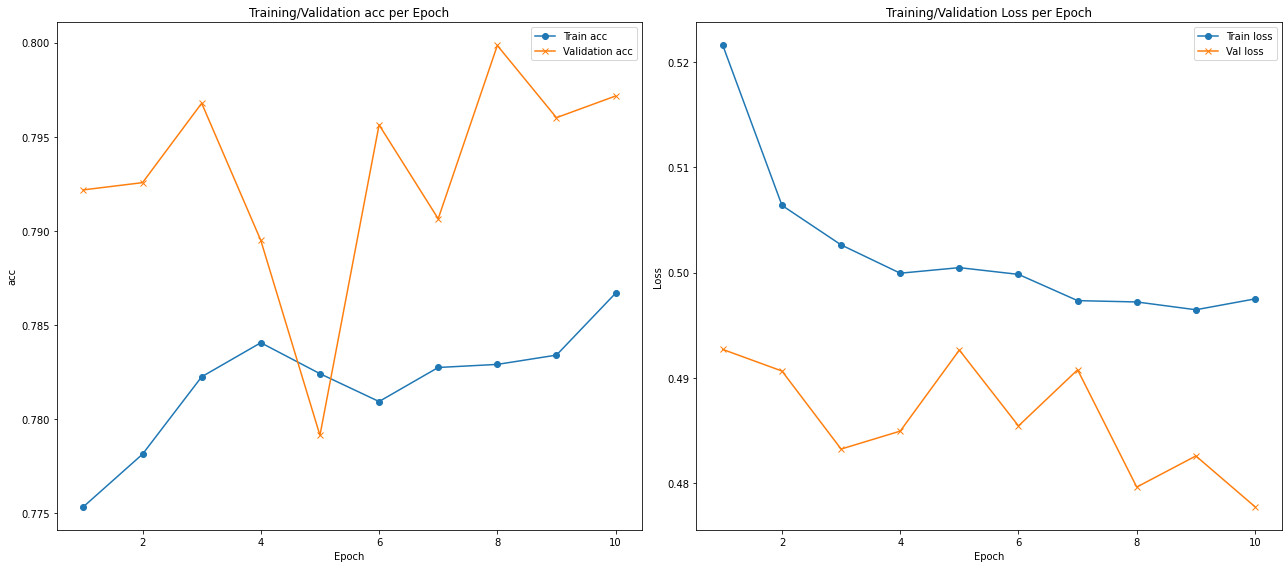

In [96]:
f, ax = plt.subplots(1, 2, figsize=[18, 8])
ax[0].plot([None] + hist.history['accuracy'], 'o-')
ax[0].plot([None] + hist.history['val_accuracy'], 'x-')
# Plot legend and use the best location automatically: loc = 0.
ax[0].legend(['Train acc', 'Validation acc'], loc = 0)
ax[0].set_title('Training/Validation acc per Epoch')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('acc')

ax[1].plot([None] + hist.history['loss'], 'o-')
ax[1].plot([None] + hist.history['val_loss'], 'x-')

# Plot legend and use the best location automatically: loc = 0.
ax[1].legend(['Train loss', "Val loss"], loc = 0)
ax[1].set_title('Training/Validation Loss per Epoch')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')

plt.tight_layout()
plt.show()

# Confusion Matrix

In [102]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)

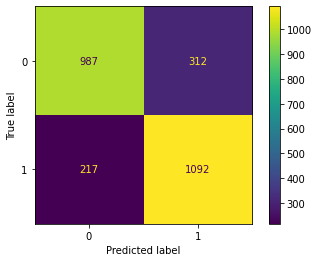

In [105]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

# Performing final predictions

In [75]:
preds = best_model.predict(test)
preds

array([[0.78563595],
       [0.05266157],
       [0.78563595],
       ...,
       [0.78563595],
       [0.67405546],
       [0.78563595]], dtype=float32)

In [76]:
survived = [1 if x > 0.5 else 0 for x in preds]
survived

[1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,


In [81]:
for i in range(len(survived)):
    survived[i] = bool(survived[i])

survived
    

[True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 True,
 False,
 False,
 False,
 True,
 True,
 False,
 True,
 False,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 False,
 True,
 True,
 False,
 False,
 True,
 False,
 True,
 True,
 False,
 True,
 False,
 False,
 True,
 False,
 True,
 True,
 False,
 True,
 False,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 False,
 True,
 False,
 False,
 True,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 True,
 True,
 False,
 True,
 True,
 False,
 False,
 True,
 False,
 False,
 False,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 False,
 False,
 False,
 False,
 True,
 False,
 True,
 True,
 Fals

In [82]:
subs = pd.DataFrame({'PassengerId': ids, 'Transported': survived})
# subs.to_csv('subs.csv', index=False)